In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Load the dataset
df = pd.read_excel("Online Retail.xlsx")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.duplicated().sum()

5268

In [7]:
# Check missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# Check unique countries
df['Country'].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [9]:
# Remove missing or negative quantities
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


In [10]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceHour'] = df['InvoiceDate'].dt.hour

In [12]:
df['InvoiceDay'] = df['InvoiceDate'].dt.day

In [13]:
# Mark each invoice as a transaction
df['Invoice'] = df['InvoiceNo'].astype(str)

In [14]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,InvoiceHour,InvoiceDay,Invoice,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,8,1,536365,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,8,1,536365,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,8,1,536365,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,8,1,536365,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,8,1,536365,20.34


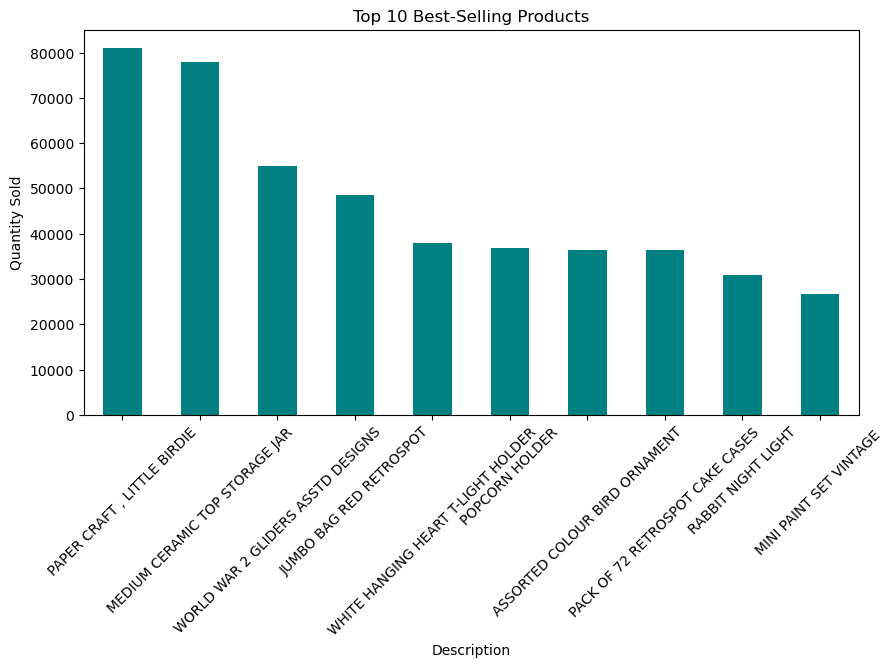

In [15]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', title='Top 10 Best-Selling Products', figsize=(10,5), color='teal')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()

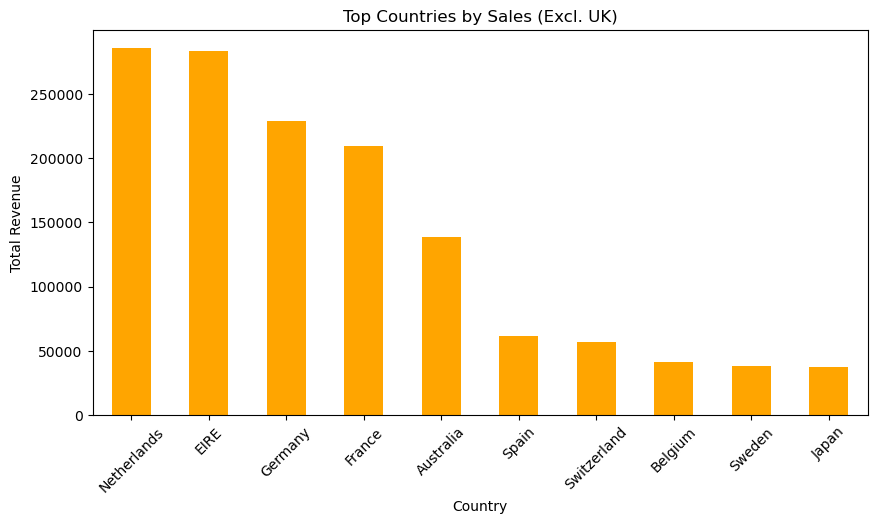

In [16]:
country_sales = df[df['Country'] != 'United Kingdom'].groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
country_sales.plot(kind='bar', title='Top Countries by Sales (Excl. UK)', figsize=(10,5), color='orange')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

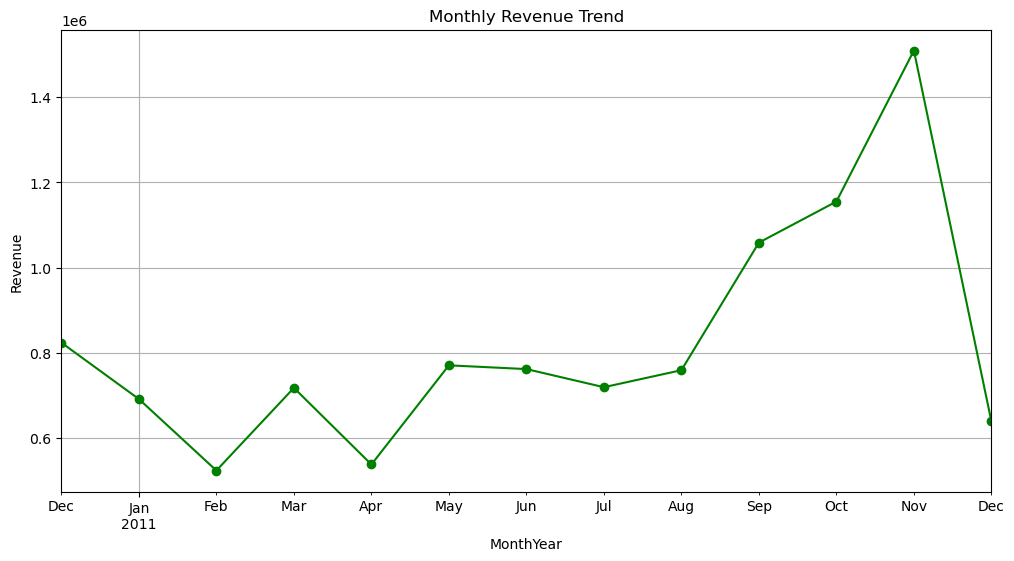

In [17]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('MonthYear')['TotalPrice'].sum()

monthly_sales.plot(kind='line', title='Monthly Revenue Trend', figsize=(12,6), marker='o', color='green')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [18]:
import datetime as dt

# Set reference date for Recency calculation
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}).dropna()

# Standardize for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


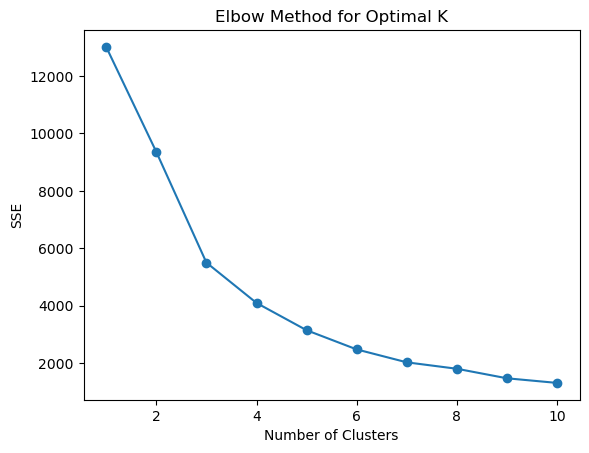

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Elbow Method to choose optimal k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()


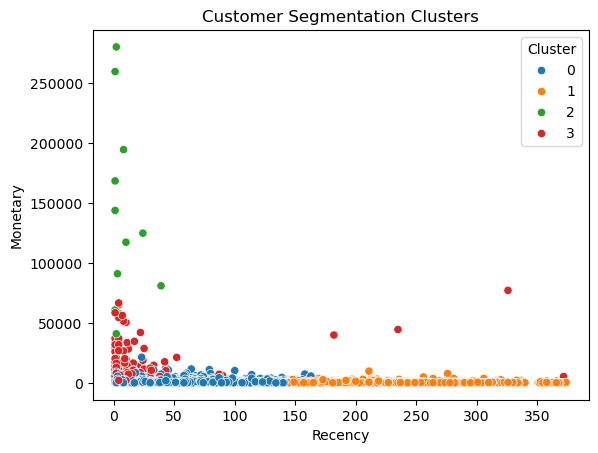

In [20]:
# Let’s assume optimal clusters = 4
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Plot clusters
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10')
plt.title("Customer Segmentation Clusters")
plt.show()


In [21]:
# Copy the working dataset
df_model = df.copy()

# Drop rows with missing CustomerID (optional)
df_model.dropna(subset=['CustomerID'], inplace=True)

# Drop non-numeric/categorical columns we won't use directly
df_model = df_model.drop(['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate'], axis=1)

# One-hot encode Country (or keep only top countries)
top_countries = df_model['Country'].value_counts().nlargest(10).index
df_model = df_model[df_model['Country'].isin(top_countries)]
df_model = pd.get_dummies(df_model, columns=['Country'], drop_first=True)

# Features and Target
X = df_model.drop(['TotalPrice'], axis=1)
y = df_model['TotalPrice']


In [22]:
X = X.drop(columns=['InvoiceMonth'])


In [29]:
X['MonthYear'] = X['MonthYear'].dt.strftime('%Y%m').astype(int)
X = X.drop(columns=['Invoice'])  # Optional but recommended

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2 Score:", r2)


RMSE: 419.30840436142256
R2 Score: 0.5241797133083015


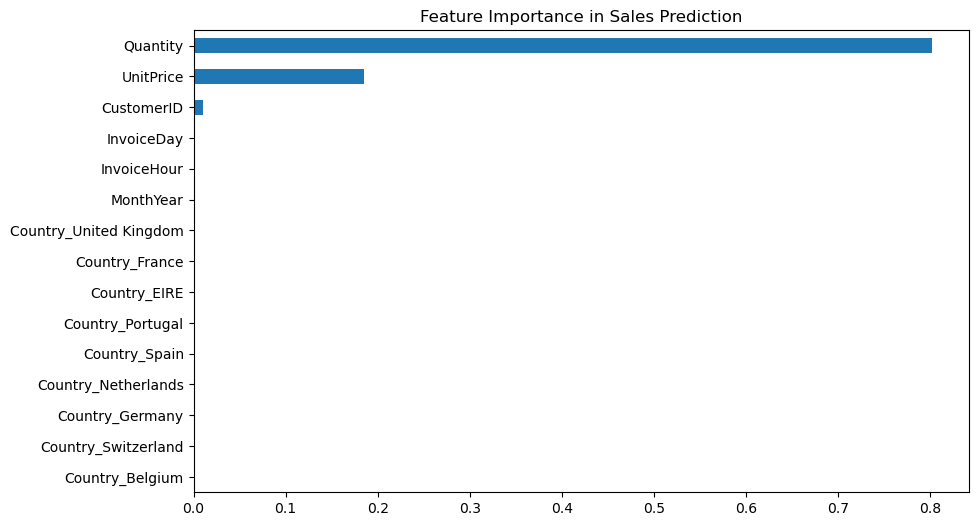

In [32]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importance in Sales Prediction")
plt.show()


In [33]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Cohort index = months since first purchase
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

invoice_year, invoice_month = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month = get_date_int(df, 'CohortMonth')

df['CohortIndex'] = (invoice_year - cohort_year) * 12 + (invoice_month - cohort_month) + 1


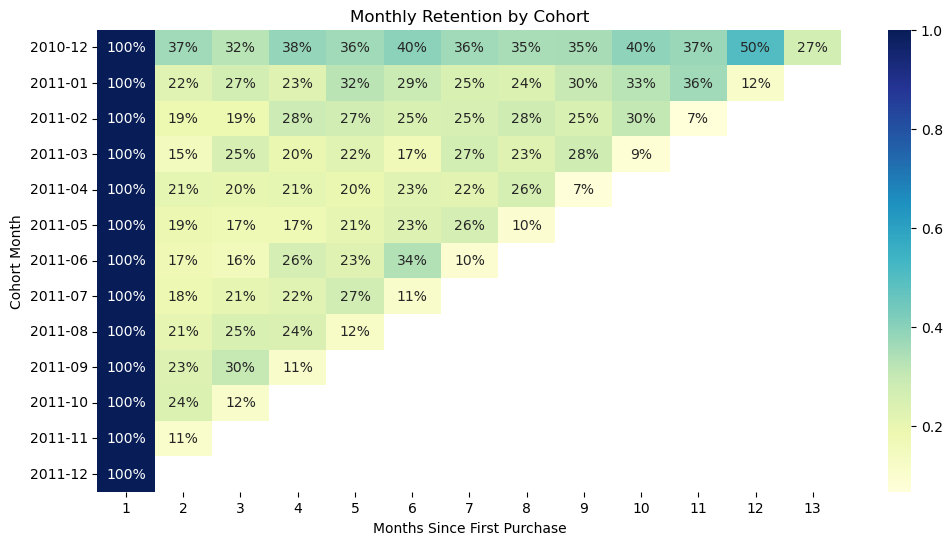

In [34]:
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Retention as %
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, cmap='YlGnBu', fmt='.0%')
plt.title('Monthly Retention by Cohort')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.show()


In [35]:
df['Sales'] = df['Quantity'] * df['UnitPrice']


In [36]:
# Remove rows with missing CustomerID
df_cust = df.dropna(subset=['CustomerID'])

# Calculate Recency (days since last purchase)
max_date = df_cust['InvoiceDate'].max()
df_cust['Recency'] = (max_date - df_cust['InvoiceDate']).dt.days

# Group by CustomerID
customer_df = df_cust.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'Invoice': 'nunique',
    'Recency': 'min',
    'InvoiceDate': ['min', 'max'],
    'Country': 'nunique',
    'Sales': 'sum'
}).reset_index()

# Rename columns
customer_df.columns = ['CustomerID', 'TotalQuantity', 'AvgUnitPrice', 'NumTransactions',
                       'Recency', 'FirstPurchaseDate', 'LastPurchaseDate', 'NumCountries', 'TotalSales']

# Calculate AvgBasketSize and AvgSalesPerTransaction
customer_df['AvgBasketSize'] = customer_df['TotalQuantity'] / customer_df['NumTransactions']
customer_df['AvgSalesPerTransaction'] = customer_df['TotalSales'] / customer_df['NumTransactions']


C:\Users\DELL\AppData\Local\Temp\ipykernel_10496\1454879736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cust['Recency'] = (max_date - df_cust['InvoiceDate']).dt.days


In [37]:
# Set the reference date as one day after the last invoice date
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                       # Frequency
    'Sales': 'sum'                                              # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm = rfm.dropna()


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [39]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

In [40]:
rfm.groupby('Segment').mean().sort_values('Monetary', ascending=False)


,CustomerID,Recency,Frequency,Monetary
Segment,,,,
2,15435.000000,7.384615,82.538462,127338.313846
3,15212.857843,15.500000,22.333333,12709.090490
0,15289.128356,43.702685,3.682711,1359.049284
1,15347.791940,248.075914,1.552015,480.617480


In [41]:
# Features and target
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R2 Score: -0.09828558180950564
RMSE: 10607.143123135373


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:
rfm['Predicted_CLV'] = model.predict(rfm[['Recency', 'Frequency']])


In [44]:
rfm['CLV_Tier'] = pd.qcut(rfm['Predicted_CLV'], q=4, labels=['Bronze', 'Silver', 'Gold', 'Platinum'])


In [45]:
rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Predicted_CLV', 'CLV_Tier']].head()


,CustomerID,Recency,Frequency,Monetary,Predicted_CLV,CLV_Tier
0,12346.0,326,1,77183.60,22480.517669,Platinum
1,12347.0,2,7,4310.00,2719.072759,Platinum
2,12348.0,75,4,1797.24,1730.633127,Platinum
3,12349.0,19,1,1757.55,384.961534,Bronze
4,12350.0,310,1,334.40,400.038062,Silver


C:\Users\DELL\AppData\Local\Temp\ipykernel_10496\2267611781.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='CLV_Tier', order=['Platinum', 'Gold', 'Silver', 'Bronze'], palette='viridis')


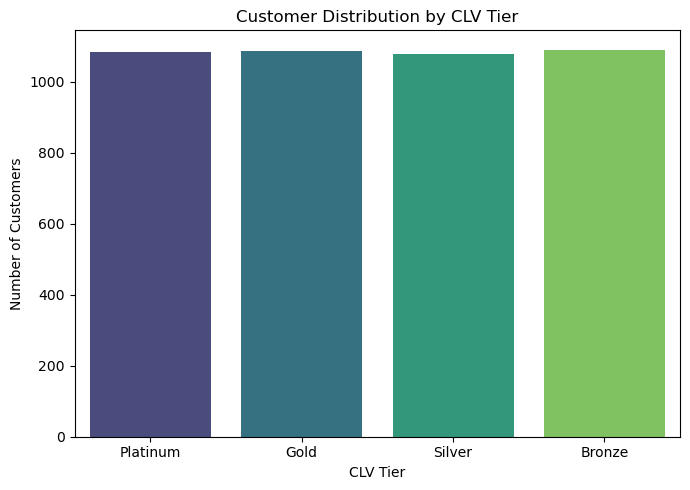

In [46]:
plt.figure(figsize=(7,5))
sns.countplot(data=rfm, x='CLV_Tier', order=['Platinum', 'Gold', 'Silver', 'Bronze'], palette='viridis')
plt.title('Customer Distribution by CLV Tier')
plt.ylabel('Number of Customers')
plt.xlabel('CLV Tier')
plt.tight_layout()
plt.show()

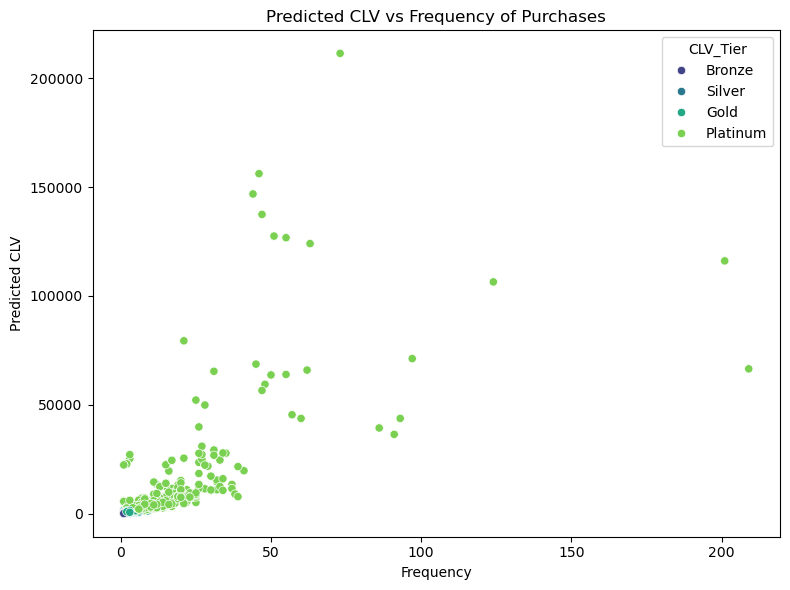

In [47]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Predicted_CLV', hue='CLV_Tier', palette='viridis')
plt.title('Predicted CLV vs Frequency of Purchases')
plt.xlabel('Frequency')
plt.ylabel('Predicted CLV')
plt.tight_layout()
plt.show()


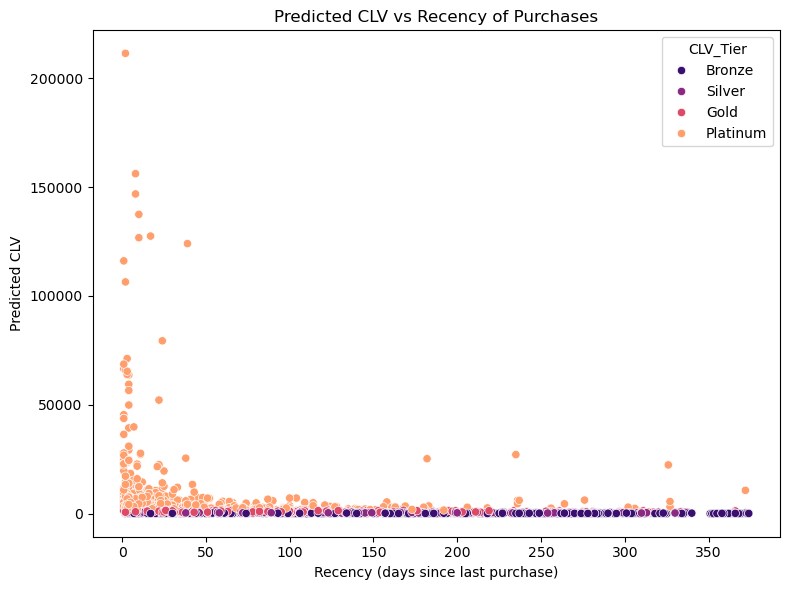

In [48]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Predicted_CLV', hue='CLV_Tier', palette='magma')
plt.title('Predicted CLV vs Recency of Purchases')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Predicted CLV')
plt.tight_layout()
plt.show()


In [49]:
rfm.to_csv("customer_clv_segments.csv", index=False)
print("File saved: customer_clv_segments.csv")


File saved: customer_clv_segments.csv


In [69]:
# --- RFM Analysis ---
# Reference date for Recency
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                # Frequency
    'TotalPrice': 'sum'                                  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Quick look
rfm.describe()


,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


In [70]:
# Create RFM Segments (quartiles)
rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Quartile'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

# Combine into RFM Score
rfm['RFM_Score'] = rfm['R_Quartile'].astype(str) + rfm['F_Quartile'].astype(str) + rfm['M_Quartile'].astype(str)

# Add Segment Label
rfm['Segment'] = rfm['RFM_Score'].apply(lambda x: 'Best' if x == '444' else 'Loyal' if x[1]=='4' else 'Others')

# View results
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,4,114,Others
1,12347.0,2,7,4310.00,4,4,4,444,Best
2,12348.0,75,4,1797.24,2,3,4,234,Others
3,12349.0,19,1,1757.55,3,1,4,314,Others
4,12350.0,310,1,334.40,1,1,2,112,Others


C:\Users\DELL\AppData\Local\Temp\ipykernel_10496\4243927150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', palette='viridis')


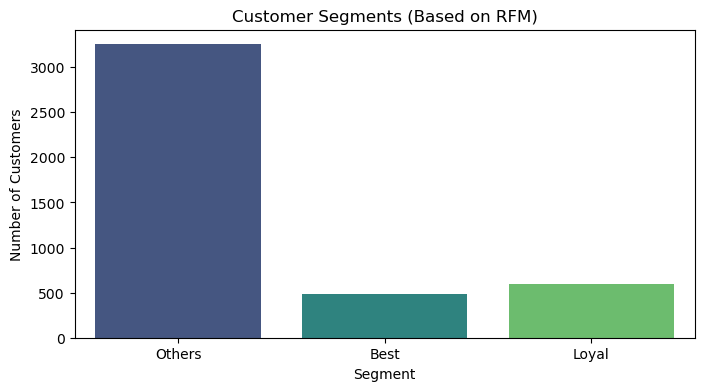

In [71]:
# Distribution of RFM Segments
plt.figure(figsize=(8,4))
sns.countplot(data=rfm, x='Segment', palette='viridis')
plt.title('Customer Segments (Based on RFM)')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()